In [1]:
# in this notebook, I will try to fit a model relating the mean behavior of L4, L2/3, SST and VIP cells

In [ ]:
# load the data

In [2]:
import pyute as ut
import autograd.numpy as np
import matplotlib.pyplot as plt
import sklearn
import h5py
import pdb
import scipy.optimize as sop
from autograd import elementwise_grad as egrad
from mpl_toolkits.mplot3d import Axes3D
import sklearn.discriminant_analysis as skd
import autograd.scipy.special as ssp
from autograd import jacobian
import size_contrast_analysis as sca
import scipy.stats as sst
import utils
from importlib import reload
reload(utils)
%matplotlib notebook

/Users/dan/Documents/code/downloads/OASIS/oasis/functions.py:14: UserWarning: Could not find cvxpy. Don't worry, you can still use OASIS, just not the slower interior point methods we compared to in the papers.
  "just not the slower interior point methods we compared to in the papers.")


In [3]:
dsbase = '/Users/dan/Documents/notebooks/mossing-PC/shared_data/'


In [4]:
nsize,ncontrast = 5,6

In [6]:
ls

Untitled.ipynb
__pycache__/
bessel_simulation.ipynb
computing_gaussian_path_integral.ipynb
contrast_sensitivity_analysis.ipynb
figures/
fit_2state_opsin_kinetics.ipynb
fit_weight_matrix.ipynb
fit_weight_matrix_draft.py
fit_weight_matrix_individual.ipynb
fit_weight_matrix_miller_troyer.ipynb
fit_weight_matrix_miller_troyer_3_celltypes.ipynb
fit_weight_matrix_miller_troyer_3_celltypes_hessian.ipynb
fit_weight_matrix_miller_troyer_3_celltypes_s02.ipynb
fit_weight_matrix_miller_troyer_data_loss.ipynb
fit_weight_matrix_miller_troyer_data_loss_spatial-Copy1.ipynb
fit_weight_matrix_miller_troyer_data_loss_spatial.ipynb
fit_weight_matrix_miller_troyer_spatial_relaxed.ipynb
fit_weight_matrix_miller_troyer_spatial_relaxed_variability.ipynb
fit_weight_matrix_miller_troyer_spatial_relaxed_variability_with_pv.ipynb
l4_l23_lda.ipynb
linear_regression.ipynb
linear_regression_190513.ipynb
linear_regression_after_pca.ipynb
linear_regression_after_pca_hdf5.ipynb
monosynaptic_exc_and_disynaptic_inh.ipynb

In [24]:
rs = np.load('rs_no_pval_criterion_200111.npy',allow_pickle=True)[()]['rs']

In [25]:
def sum_to_1(r):
    R = r.reshape((r.shape[0],-1))
    R = R/np.nansum(R[:,~np.isnan(R.sum(0))],axis=1)[:,np.newaxis]
    return R
Rs = [[None,None] for i in range(len(rs))]
for iR,r in enumerate(rs):
    for ialign in range(2):
        Rs[iR][ialign] = sum_to_1(r[ialign])

<IPython.core.display.Javascript object>


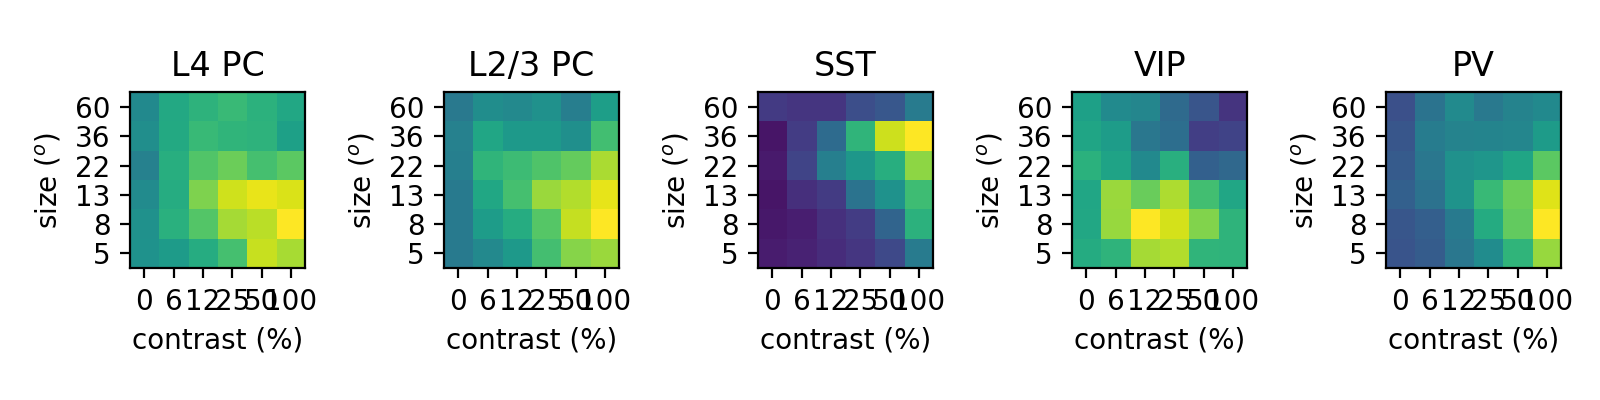

<IPython.core.display.Javascript object>


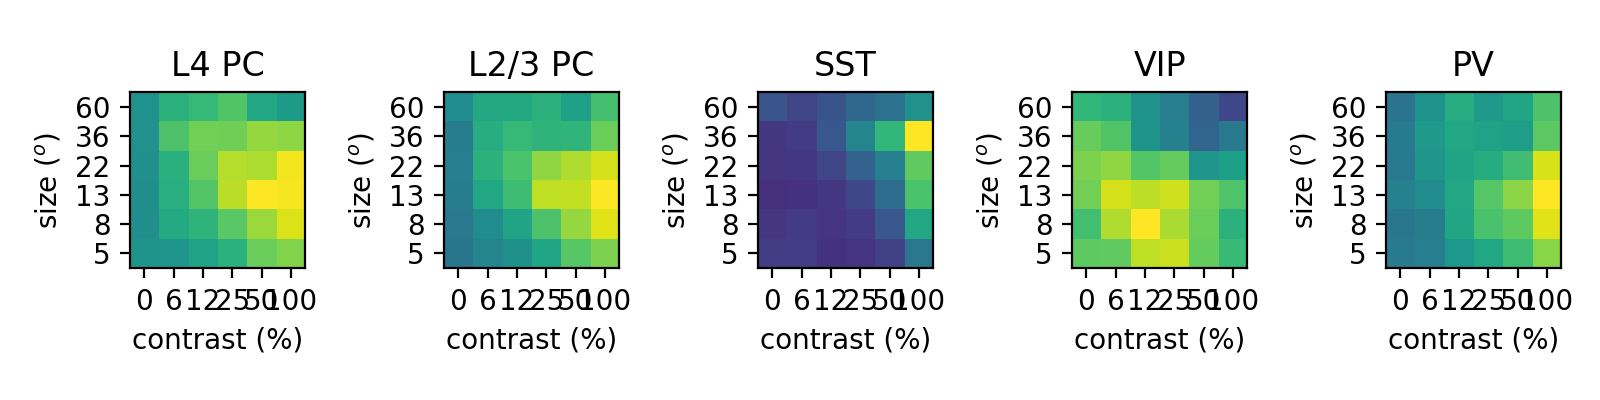

In [26]:
ucontrast = [str(c) for c in np.array((0,6,12,25,50,100))]
usize = [str(s) for s in (5,8,13,22,36)]
celltypes = ['L4 PC', 'L2/3 PC', 'SST', 'VIP', 'PV']
ntypes = len(celltypes)
# aligntypes = ['RF distance <10$^o$']
# saveas = ['figures/four_cell_types_aligned.pdf','figures/four_cell_types_misaligned.pdf']
for ialign in range(2):
    plt.figure(figsize=(8,2))
    for icelltype in range(ntypes):
        plt.subplot(1,ntypes,icelltype+1)
        if not rs[icelltype][ialign] is None:
            to_show = np.nanmean(Rs[icelltype][ialign],0).reshape((6,6))
            sca.show_size_contrast(to_show,flipud=True,usize=[5,8,13,22,36,60],vmin=0,vmax=np.nanmax(to_show))
        plt.title(celltypes[icelltype])
    plt.tight_layout()
#     plt.savefig(saveas[ialign])

In [32]:
def plot_size_tuning_by_contrast(arr,cs):
    usize = np.array((0,8,13,22,36))
    to_plot = arr.mean(0)
    arr_sz = gen_size_tuning(arr)
    arr_sz = arr_sz/arr_sz.max(1).max(1).max(1)[:,np.newaxis,np.newaxis,np.newaxis]
    lb,ub = ut.bootstrap(arr_sz,np.mean,pct=(2.5,97.5))
    colors = ['k','r']
    lbls = ['light off','light on']
    to_plot = arr_sz.mean(0)
    for ic,c in enumerate(cs):
        plt.subplot(1,len(cs),ic+1)
        for il in range(2):
            ut.plot_bootstrapped_errorbars_hillel(usize,arr_sz[:,:,c:c+1,il].transpose((0,2,1)),markersize=5,colors=colors[il])
        plt.ylim(to_plot.min()-0.1,to_plot.max()+0.1)
        plt.xlabel('size ($^o$)')
    plt.legend(lbls)
    plt.subplot(1,len(cs),1)
    plt.ylabel('event rate / max event rate')
#     plt.tight_layout()

def gen_size_tuning(sc):
    gray = np.tile(sc[:,0].mean(0)[np.newaxis,np.newaxis],(1,sc.shape[1]))
    to_plot = np.concatenate((gray,sc),axis=0)
    return to_plot

In [27]:
ncelltypes = len(Rs)

In [129]:
# import autograd.numpy as np
# from autograd import grad
# import scipy.optimize as sop

# # def naka_rushton(c,params):
# #     a = params[0]
# #     b = params[1]
# #     c50 = params[2]
# #     n = params[3]
# #     return (a*(c/c50)**n + b)/(1+(c/c50)**n)

# def fit_opt_params_(c,r):
#     if np.all(~np.isnan(r)):
#         a_0 = r.max()
#         b_0 = 1e-12
#         c50_0 = 50
#         n_0 = 1
#         params_0 = np.array((a_0,b_0,c50_0,n_0))
#         params_opt = sop.least_squares(lambda params: r-nra.naka_rushton(c,params),params_0,bounds=((0,0,0,1-1e-12),(np.inf,np.inf,500,1+1e-12)))
#         return params_opt['x']
#     else:
#         return None
        
# def fit_crfs(arr,contrast_axis=2):
#     popt = np.zeros(arr.shape[0:contrast_axis]+(4,))
#     for iroi in range(arr.shape[0]):
#         for isize in range(arr.shape[1]):
#             popt[iroi,isize] = fit_opt_params_(cvals,arr[iroi,isize])
#     return popt #np.diff(arr,axis=contrast_axis)

# arr = Rs[1][0].reshape((-1,nsize,ncontrast))

# def compute_size_contrast_deriv(arr,popt=None,cvals=np.array([0,6,12,25,50,100])):
    
#     if popt is None:
#         popt = fit_crfs(arr,contrast_axis=2)

#     nr_contrast_deriv = np.zeros(arr.shape)
#     for iroi in range(nr_deriv.shape[0]):
#         for isize in range(nr_deriv.shape[1]):
#             params = popt[iroi,isize]
#             nr_contrast_deriv[iroi,isize] = grad(lambda c: naka_rushton(c,params))(cvals)

#     modeled = np.array([[naka_rushton(cvals,popt[iroi,isize]) for isize in range(popt.shape[1])] for iroi in range(popt.shape[0])])
#     nr_size_slope = np.nanmean(np.abs(np.diff(modeled,axis=1)),axis=0)
#     nr_size_deriv = np.zeros((nr_size_slope.shape[0]+1,nr_size_slope.shape[1]))
#     nr_size_deriv[0] = nr_size_slope[0]
#     nr_size_deriv[-1] = nr_size_slope[-1]
#     nr_size_deriv[1:-1] = 0.5*(nr_size_slope[1:]+nr_size_slope[:-1])

#     return popt,nr_contrast_deriv,nr_size_deriv

In [61]:
nsize,ncontrast = 6,6
usize=[5,8,13,22,36,60]
ucontrast = [0,6,12,25,50,100]
cvals = np.array([int(i) for i in ucontrast])

In [50]:
sensitivity = compute_contrast_sensitivity(Rs[1][0].reshape((-1,nsize,ncontrast)),contrast_axis=2)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
27

In [112]:
iroi = 0
modeled = np.array([[naka_rushton(cvals,sensitivity[iroi,isize]) for isize in range(sensitivity.shape[1])] for iroi in range(sensitivity.shape[0])])
nr_size_slope = np.nanmean(np.abs(np.diff(modeled,axis=1)),axis=0)
nr_size_deriv = np.zeros((nr_size_slope.shape[0]+1,nr_size_slope.shape[1]))
nr_size_deriv[0] = nr_size_slope[0]
nr_size_deriv[-1] = nr_size_slope[-1]
nr_size_deriv[1:-1] = 0.5*(nr_size_slope[1:]+nr_size_slope[:-1])

<IPython.core.display.Javascript object>


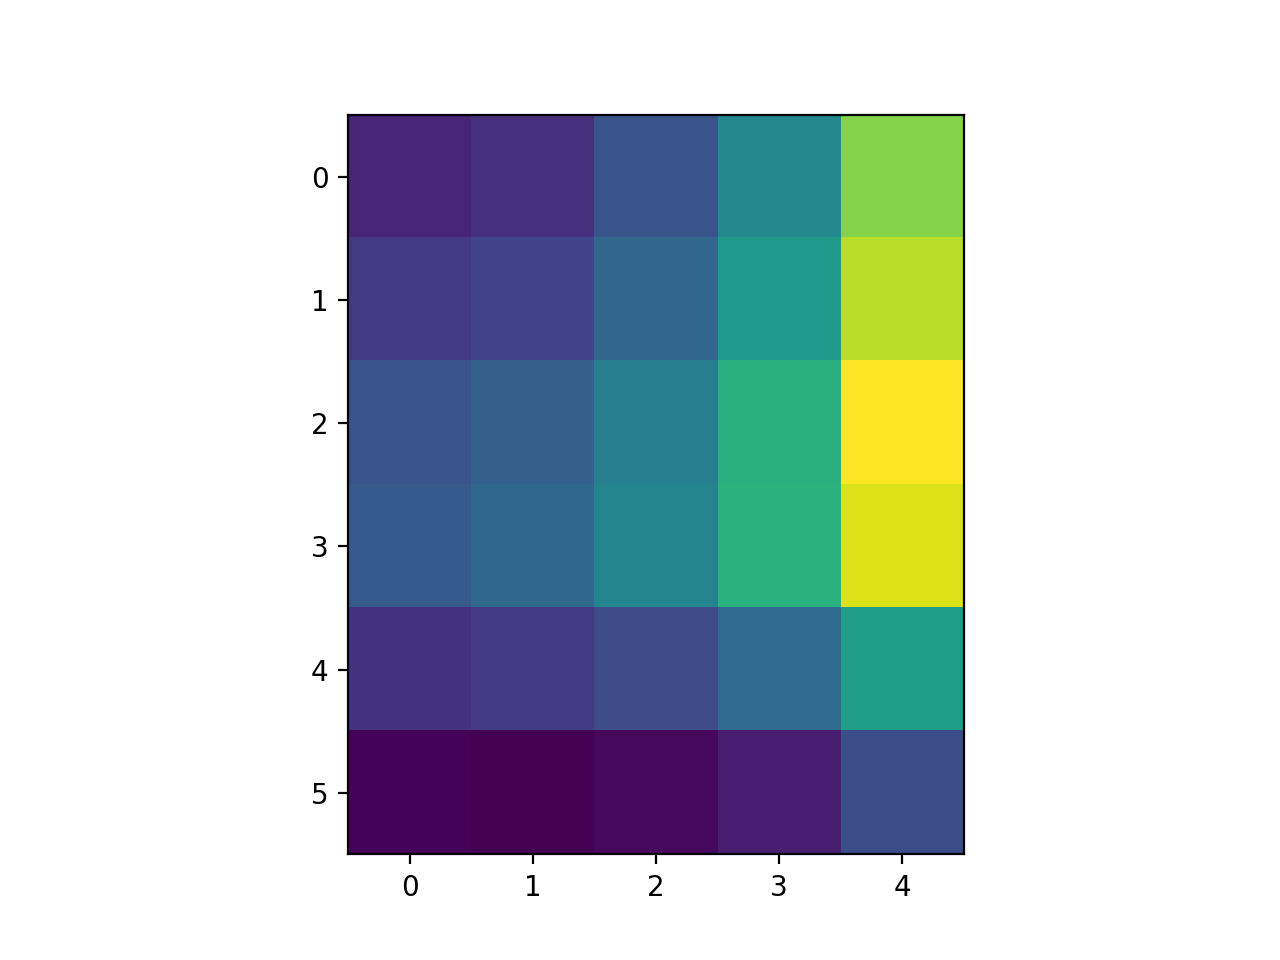

In [114]:
plt.figure()
plt.imshow(nr_size_deriv[:,1:])

In [55]:
def compute_nr_deriv(params):
    return egrad(lambda c: naka_rushton(c,params))(cvals)

In [66]:
nr_deriv = np.zeros(Rs[1][0].reshape((-1,nsize,ncontrast)).shape)
for iroi in range(nr_deriv.shape[0]):
    for isize in range(nr_deriv.shape[1]):
        params = sensitivity[iroi,isize]
        nr_deriv[iroi,isize] = egrad(lambda c: naka_rushton(c,params))(cvals)

In [98]:
sensitivity[0].shape

(6, 4)

<IPython.core.display.Javascript object>


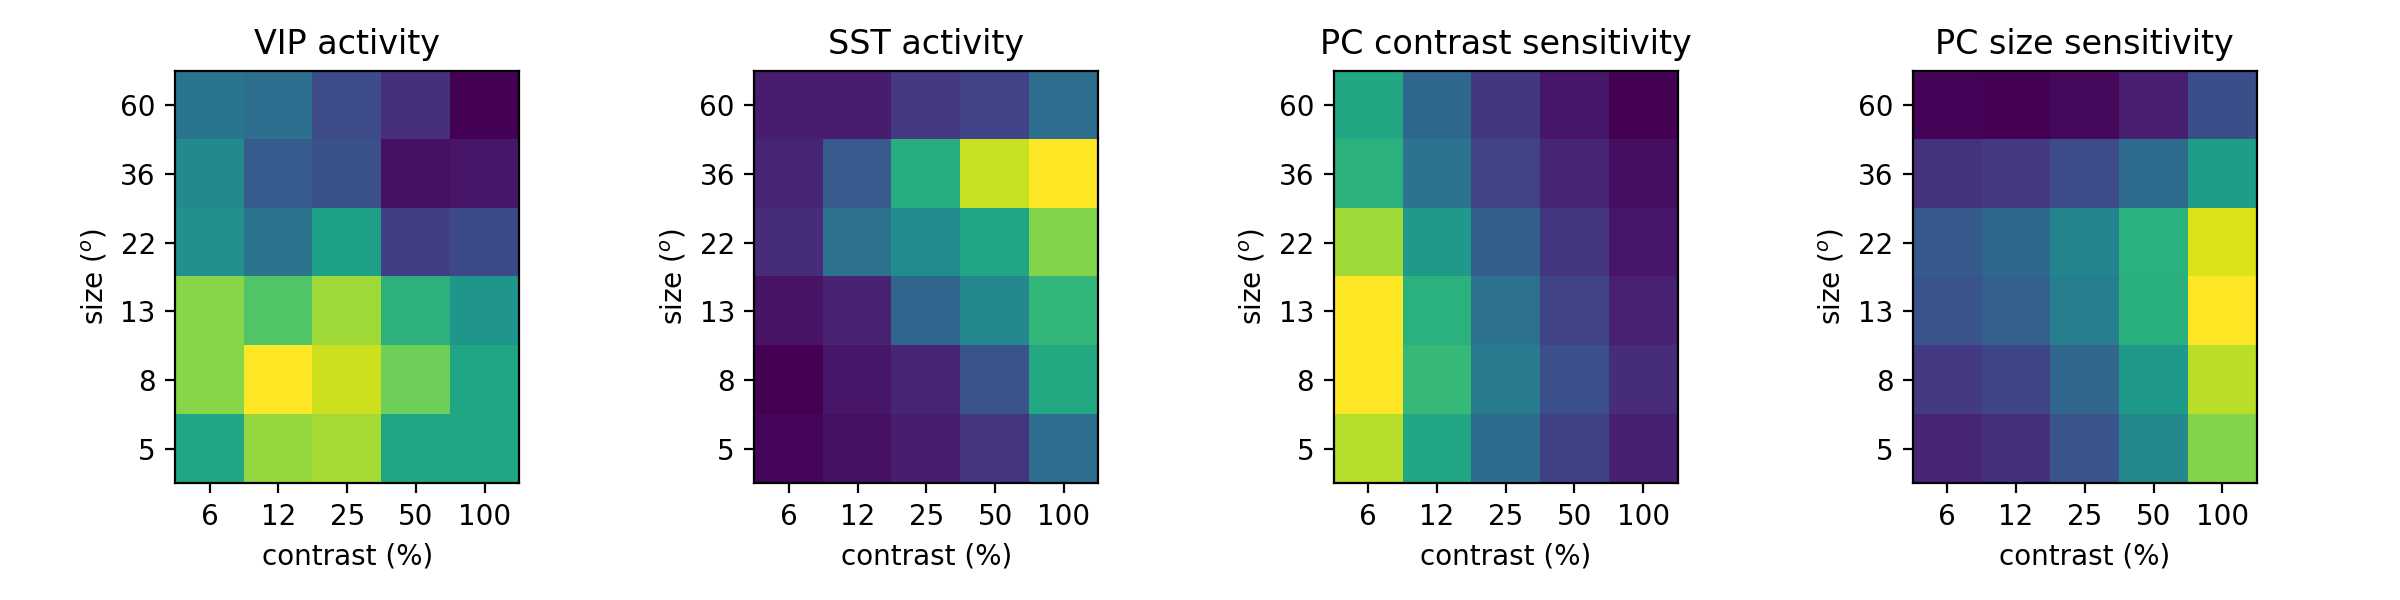

In [127]:
mag = 3
plt.figure(figsize=(mag*4,mag*1))
plt.subplot(1,4,2)
plt.title('SST activity')
sca.show_size_contrast(np.nanmean(Rs[2][0].reshape((-1,nsize,ncontrast)),0)[:,1:],flipud=True,ucontrast=ucontrast[1:],usize=usize)
plt.subplot(1,4,1)
plt.title('VIP activity')
sca.show_size_contrast(np.nanmean(Rs[3][0].reshape((-1,nsize,ncontrast)),0)[:,1:],flipud=True,ucontrast=ucontrast[1:],usize=usize)
plt.subplot(1,4,3)
plt.title('PC contrast sensitivity')
sca.show_size_contrast(np.nanmean(np.abs(nr_deriv),0)[:,1:],flipud=True,ucontrast=ucontrast[1:],usize=usize)
plt.tight_layout()
plt.subplot(1,4,4)
plt.title('PC size sensitivity')
sca.show_size_contrast(nr_size_deriv[:,1:],flipud=True,ucontrast=ucontrast[1:],usize=usize)
plt.tight_layout()
ut.mkdir('figures')
# plt.savefig('figures/sst_vip_sensitivity.jpg',dpi=300)

<IPython.core.display.Javascript object>


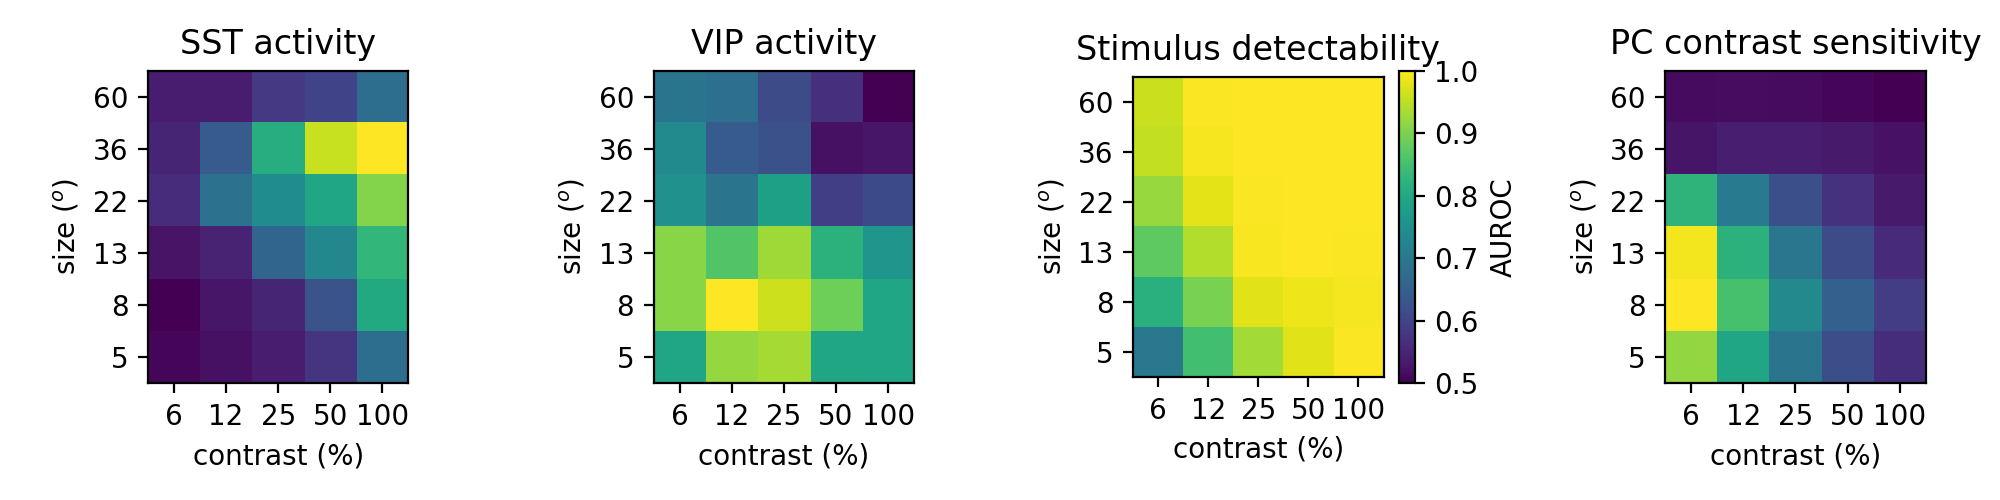

In [86]:
auroc_mean = np.load('../shared_data/pyr_l23_population_detection_by_size_and_contrast_auroc.npy')
mag = 2.5
reload(ut)
reload(sca)
plt.figure(figsize=(4*mag,mag))
plt.subplot(1,4,1)
plt.title('SST activity')
sca.show_size_contrast(np.nanmean(Rs[2][0].reshape((-1,nsize,ncontrast)),0)[:,1:],flipud=True,ucontrast=ucontrast[1:],usize=usize)
plt.subplot(1,4,2)
plt.title('VIP activity')
sca.show_size_contrast(np.nanmean(Rs[3][0].reshape((-1,nsize,ncontrast)),0)[:,1:],flipud=True,ucontrast=ucontrast[1:],usize=usize)
plt.subplot(1,4,4)
plt.title('PC contrast sensitivity')
sca.show_size_contrast(np.nanmean(nr_deriv,0)[:,1:],flipud=True,ucontrast=ucontrast[1:],usize=usize)
plt.subplot(1,4,3)
plt.title('Stimulus detectability')
sca.show_auroc(np.nanmean(auroc_mean,0),usize=usize,ucontrast=ucontrast,label='AUROC')
plt.tight_layout()
ut.mkdir('figures')
plt.savefig('figures/sst_vip_detectability_sensitivity.jpg',dpi=300)

In [122]:
cvals

array([  0,   6,  12,  25,  50, 100])

<IPython.core.display.Javascript object>


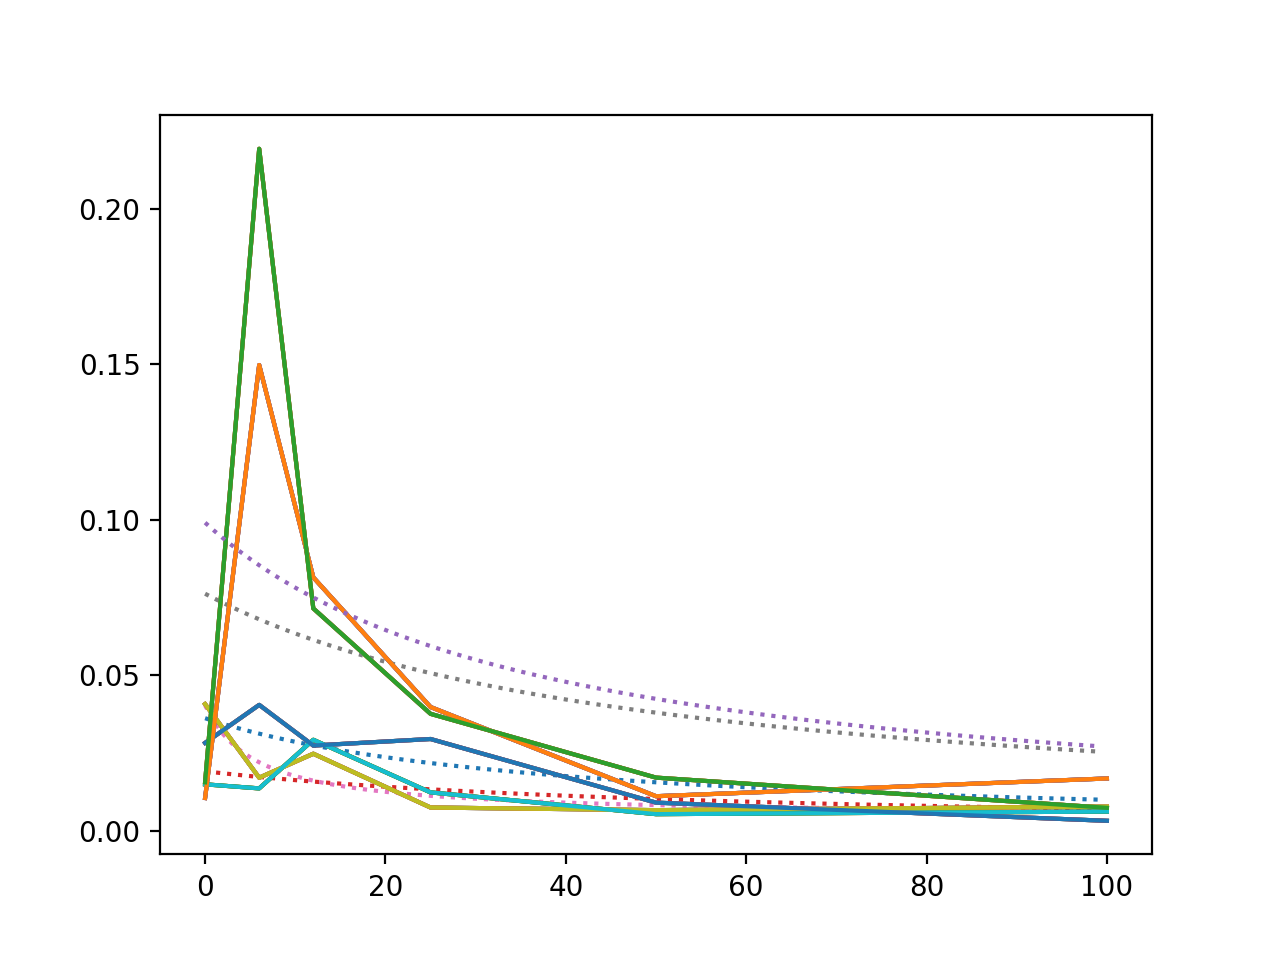

In [126]:
plt.figure()
iroi = 3
for isize in range(5):
    plt.plot(cvals,Rs[1][0].reshape((-1,nsize,ncontrast))[iroi].T)
    plt.plot(naka_rushton(np.arange(100),sensitivity[iroi,isize]),linestyle='dotted')

<IPython.core.display.Javascript object>


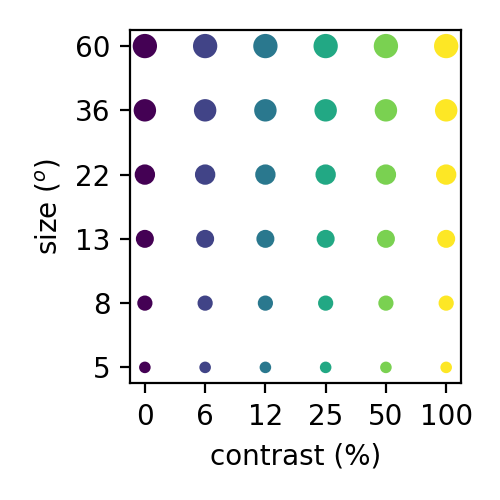

In [96]:
plt.figure(figsize=(2.5,2.5))
xx,yy = np.meshgrid(np.arange(6),np.arange(6))
xx = xx.flatten()
yy = yy.flatten()
sca.scatter_size_contrast(xx,yy,nsize=6,ncontrast=6,equality_line=False,square=True)
plt.xticks(np.arange(6),(0,6,12,25,50,100))
plt.xlabel('contrast (%)')
plt.yticks(np.arange(6),(5,8,13,22,36,60))
plt.ylabel('size ($^o$)')
# plt.axis('equal')
plt.tight_layout()
plt.savefig('figures/size_contrast_scatter_legend.jpg',dpi=300)
# plt.axis('off')